### Dataset
- https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [5]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("indians-dibetes-analisys").getOrCreate()
from pyspark.sql.functions import *
import os
os.environ['SPARK_HOME'] = r'C:\spark\spark-3.3.2-bin-hadoop2'

In [9]:
df = spark.read.format('com.databricks.spark.csv') \
    .options(header='true',inferschema='true') \
    .load("/kaggle/input/pima-indians-diabetes-database")

In [10]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [11]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
# imprime a distribuição das classes
df.groupBy('outcome').count().collect()

[Row(outcome=1, count=268), Row(outcome=0, count=500)]

([<matplotlib.axis.XTick at 0x73bbd84af790>,
 [Text(0.175, 0, '1'), Text(1.175, 0, '0')])

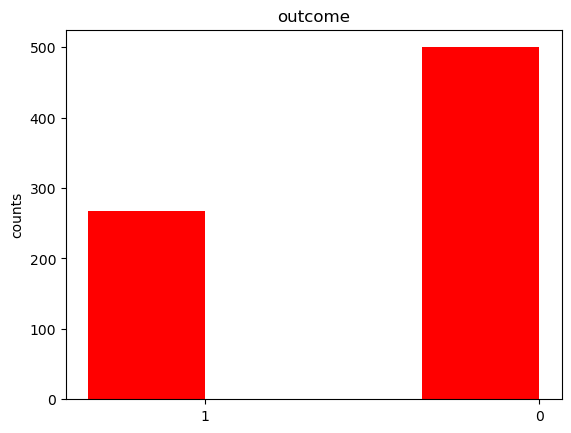

In [13]:
# plota a distribuição dos dados
import numpy as np
import matplotlib.pyplot as plt

responses = df.groupBy('outcome').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('outcome')
plt.xticks(ind + width/2., categories)

In [15]:
# estatística descritiva
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

### Spark MLlib:
- MLlib espera que todas as features estejam em um único vetor.  
- Spark DataFrames sao imutaveis, logo para fazer transformacoes iremos criar novas colunas.
- Usaremos o objeto VectorAssembler para inserir varias colunas como entrada colocar todas em uma unico array.
- Documentação oficial: https://spark.apache.org/docs/latest/ml-guide.html

In [16]:
# Cria o objeto lr (logistic regression)
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

In [17]:
from pyspark.ml.feature import VectorAssembler

In [18]:
# cria o objeto assembler
assembler = VectorAssembler(
    inputCols=["Pregnancies", "Glucose", "BloodPressure",'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'],
    outputCol="features")

In [19]:
# aplica o assembler
df_transform = assembler.transform(df)

In [20]:
df_transform.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|            features|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|[6.0,148.0,72.0,3...|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|[1.0,85.0,66.0,29...|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|[8.0,183.0,64.0,0...|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|[1.0,89.0,66.0,23...|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|[0.0,137.0,40.0,3...|
|          5|    116|           

In [21]:
# seleciona as features
df_2 = df_transform.select("features", "outcome")

In [22]:
# imprime o dataframe
df_2.show(5)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|[6.0,148.0,72.0,3...|      1|
|[1.0,85.0,66.0,29...|      0|
|[8.0,183.0,64.0,0...|      1|
|[1.0,89.0,66.0,23...|      0|
|[0.0,137.0,40.0,3...|      1|
+--------------------+-------+
only showing top 5 rows



In [23]:
# renomea a coluna outcome para label
df_2 = df_2.withColumnRenamed('outcome','label')

In [24]:
df_2.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[6.0,148.0,72.0,3...|    1|
|[1.0,85.0,66.0,29...|    0|
|[8.0,183.0,64.0,0...|    1|
|[1.0,89.0,66.0,23...|    0|
|[0.0,137.0,40.0,3...|    1|
|[5.0,116.0,74.0,0...|    0|
|[3.0,78.0,50.0,32...|    1|
|[10.0,115.0,0.0,0...|    0|
|[2.0,197.0,70.0,4...|    1|
|[8.0,125.0,96.0,0...|    1|
|[4.0,110.0,92.0,0...|    0|
|[10.0,168.0,74.0,...|    1|
|[10.0,139.0,80.0,...|    0|
|[1.0,189.0,60.0,2...|    1|
|[5.0,166.0,72.0,1...|    1|
|[7.0,100.0,0.0,0....|    1|
|[0.0,118.0,84.0,4...|    1|
|[7.0,107.0,74.0,0...|    1|
|[1.0,103.0,30.0,3...|    0|
|[1.0,115.0,70.0,3...|    1|
+--------------------+-----+
only showing top 20 rows



In [25]:
# separando 80% dos dados para treino e 20% para test
train, test = df_2.randomSplit([0.8, 0.2], seed=100)

In [26]:
test.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(8,[0,1,6,7],[6.0...|    0|
|(8,[1,5,6,7],[131...|    1|
|(8,[1,5,6,7],[167...|    1|
|[0.0,84.0,64.0,22...|    0|
|[0.0,93.0,60.0,0....|    0|
|[0.0,95.0,64.0,39...|    0|
|[0.0,100.0,70.0,2...|    0|
|[0.0,100.0,88.0,6...|    0|
|[0.0,101.0,64.0,1...|    0|
|[0.0,101.0,65.0,2...|    0|
|[0.0,102.0,52.0,0...|    0|
|[0.0,102.0,64.0,4...|    0|
|[0.0,106.0,70.0,3...|    0|
|[0.0,111.0,65.0,0...|    0|
|[0.0,113.0,76.0,0...|    1|
|[0.0,118.0,84.0,4...|    1|
|[0.0,124.0,56.0,1...|    0|
|[0.0,127.0,80.0,3...|    0|
|[0.0,134.0,58.0,2...|    0|
|[0.0,146.0,82.0,0...|    0|
+--------------------+-----+
only showing top 20 rows



In [27]:
# Treina o algoritmo
lrModel = lr.fit(train)

In [28]:
# armazena as predições
predictions = lrModel.transform(test)

In [29]:
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(8,[0,1,6,7],[6.0...|    0|[3.25162386561716...|[0.96273142015816...|       0.0|
|(8,[1,5,6,7],[131...|    1|[-0.3424712768943...|[0.41520929953799...|       1.0|
|(8,[1,5,6,7],[167...|    1|[-1.5647631858748...|[0.17296422296500...|       1.0|
|[0.0,84.0,64.0,22...|    0|[2.44610788484443...|[0.92027636166669...|       0.0|
|[0.0,93.0,60.0,0....|    0|[2.28487547803117...|[0.90761666239394...|       0.0|
|[0.0,95.0,64.0,39...|    0|[1.58277138326314...|[0.82959665541050...|       0.0|
|[0.0,100.0,70.0,2...|    0|[2.26587982852499...|[0.90601152246091...|       0.0|
|[0.0,100.0,88.0,6...|    0|[0.60200132277246...|[0.64611404375051...|       0.0|
|[0.0,101.0,64.0,1...|    0|[3.35162509276083...|[0.96615801129647...|       0.0|
|[0.0,101.0,65.0

In [30]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [31]:
# Imprime os coeficients dos modelos
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.1075782461394775,0.03707639007031463,-0.009102076031397578,-0.003789546826188713,-2.8006681602326252e-05,0.08128507010998803,1.2068019679202053,0.021719702725356588]
Intercept: -8.91659965326609


In [32]:
# calcula a acurácia no conjunto de teste.
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.7310344827586207


### Preprocessing

In [33]:
from pyspark.ml.feature import StandardScaler

In [34]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [36]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(train)

In [37]:
scalerModel

StandardScalerModel: uid=StandardScaler_4890ad60d292, numFeatures=8, withMean=false, withStd=true

In [38]:
# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(train)
scaledData.show()

+--------------------+-----+--------------------+
|            features|label|      scaledFeatures|
+--------------------+-----+--------------------+
|(8,[0,1,6,7],[2.0...|    0|(8,[0,1,6,7],[0.5...|
|(8,[0,1,6,7],[2.0...|    0|(8,[0,1,6,7],[0.5...|
|(8,[0,1,6,7],[3.0...|    0|(8,[0,1,6,7],[0.8...|
|(8,[0,1,6,7],[7.0...|    0|(8,[0,1,6,7],[2.0...|
|(8,[0,1,6,7],[10....|    1|(8,[0,1,6,7],[2.9...|
|(8,[1,5,6,7],[73....|    0|(8,[1,5,6,7],[2.2...|
|(8,[1,5,6,7],[99....|    0|(8,[1,5,6,7],[3.0...|
|(8,[1,5,6,7],[117...|    0|(8,[1,5,6,7],[3.6...|
|(8,[1,5,6,7],[119...|    1|(8,[1,5,6,7],[3.6...|
|(8,[1,5,6,7],[138...|    1|(8,[1,5,6,7],[4.2...|
|(8,[1,5,6,7],[141...|    1|(8,[1,5,6,7],[4.3...|
|(8,[1,5,6,7],[145...|    1|(8,[1,5,6,7],[4.5...|
|(8,[1,6,7],[94.0,...|    0|(8,[1,6,7],[2.919...|
|[0.0,57.0,60.0,0....|    0|[0.0,1.7704871306...|
|[0.0,67.0,76.0,0....|    0|[0.0,2.0810989079...|
|[0.0,74.0,52.0,10...|    0|[0.0,2.2985271520...|
|[0.0,78.0,88.0,29...|    0|[0.0,2.4227718629...|


In [39]:
scaledData = scaledData.drop('features')
scaledData.show()

+-----+--------------------+
|label|      scaledFeatures|
+-----+--------------------+
|    0|(8,[0,1,6,7],[0.5...|
|    0|(8,[0,1,6,7],[0.5...|
|    0|(8,[0,1,6,7],[0.8...|
|    0|(8,[0,1,6,7],[2.0...|
|    1|(8,[0,1,6,7],[2.9...|
|    0|(8,[1,5,6,7],[2.2...|
|    0|(8,[1,5,6,7],[3.0...|
|    0|(8,[1,5,6,7],[3.6...|
|    1|(8,[1,5,6,7],[3.6...|
|    1|(8,[1,5,6,7],[4.2...|
|    1|(8,[1,5,6,7],[4.3...|
|    1|(8,[1,5,6,7],[4.5...|
|    0|(8,[1,6,7],[2.919...|
|    0|[0.0,1.7704871306...|
|    0|[0.0,2.0810989079...|
|    0|[0.0,2.2985271520...|
|    0|[0.0,2.4227718629...|
|    0|[0.0,2.6091389293...|
|    0|[0.0,2.6712612847...|
|    0|[0.0,2.8265671734...|
+-----+--------------------+
only showing top 20 rows



In [41]:
# renomea a coluna outcome para label
scaledData = scaledData.withColumnRenamed('scaledFeatures','features')
scaledData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(8,[0,1,6,7],[0.5...|
|    0|(8,[0,1,6,7],[0.5...|
|    0|(8,[0,1,6,7],[0.8...|
|    0|(8,[0,1,6,7],[2.0...|
|    1|(8,[0,1,6,7],[2.9...|
|    0|(8,[1,5,6,7],[2.2...|
|    0|(8,[1,5,6,7],[3.0...|
|    0|(8,[1,5,6,7],[3.6...|
|    1|(8,[1,5,6,7],[3.6...|
|    1|(8,[1,5,6,7],[4.2...|
|    1|(8,[1,5,6,7],[4.3...|
|    1|(8,[1,5,6,7],[4.5...|
|    0|(8,[1,6,7],[2.919...|
|    0|[0.0,1.7704871306...|
|    0|[0.0,2.0810989079...|
|    0|[0.0,2.2985271520...|
|    0|[0.0,2.4227718629...|
|    0|[0.0,2.6091389293...|
|    0|[0.0,2.6712612847...|
|    0|[0.0,2.8265671734...|
+-----+--------------------+
only showing top 20 rows



In [42]:
# Treina o algoritmo
lrModel = lr.fit(scaledData)

### Aplica o Scaler nos dados de teste

In [ ]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(test)

scaledData = scalerModel.transform(test)

scaledData = scaledData.drop('features')
scaledData.show()

# renomea a coluna outcome para label
scaledData = scaledData.withColumnRenamed('scaledFeatures','features')
scaledData.show()

+-----+--------------------+
|label|      scaledFeatures|
+-----+--------------------+
|    0|(8,[0,1,6,7],[1.8...|
|    1|(8,[1,5,6,7],[4.2...|
|    1|(8,[1,5,6,7],[5.3...|
|    0|[0.0,2.7006556591...|
|    0|[0.0,2.9900116225...|
|    0|[0.0,3.0543129478...|
|    0|[0.0,3.2150662608...|
|    0|[0.0,3.2150662608...|
|    0|[0.0,3.2472169234...|
|    0|[0.0,3.2472169234...|
|    0|[0.0,3.2793675860...|
|    0|[0.0,3.2793675860...|
|    0|[0.0,3.4079702365...|
|    0|[0.0,3.5687235495...|
|    1|[0.0,3.6330248747...|
|    1|[0.0,3.7937781878...|
|    0|[0.0,3.9866821634...|
|    0|[0.0,4.0831341512...|
|    0|[0.0,4.3081887895...|
|    0|[0.0,4.6939967408...|
+-----+--------------------+
only showing top 20 rows

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(8,[0,1,6,7],[1.8...|
|    1|(8,[1,5,6,7],[4.2...|
|    1|(8,[1,5,6,7],[5.3...|
|    0|[0.0,2.7006556591...|
|    0|[0.0,2.9900116225...|
|    0|[0.0,3.0543129478...|
|    0|[0.0,3.215

In [43]:
# armazena as predições
predictions = lrModel.transform(scaledData)

In [44]:
# calcula a acurácia no conjunto de teste.
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.7784911717495987


### Trabalhando com CrossValidation

In [45]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [46]:
# separando 80% dos dados para treino e 20% para test
train, test = df_2.randomSplit([0.8, 0.2], seed=12345)

In [47]:
# cria o objeto de regressão logística
lr = LogisticRegression(maxIter=10)

In [48]:
# Usaremos o ParamGridBuilder para construir um grid com parâmetros para serem percorridos
# TrainValidationSplit irá tentar todas as combinacoes de valors para determinar o melhor modelo

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

In [49]:
# O estimator é um simples Logistic regression.
# A TrainValidationSplit requer um Estimator, um conjunto de estimator de parâmetros e um Evaluator.
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(),
                           trainRatio=0.8)

In [50]:
# Executa o TrainValidationSplit, e escolhe o melhor conjunto de parametros
model = tvs.fit(train)

In [52]:
# Faz predicoes com o conjunto de teste.
model.transform(test)\
    .select("features", "label", "prediction")\
    .show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(8,[1,5,6,7],[73....|    0|       0.0|
|[0.0,91.0,80.0,0....|    0|       0.0|
|[0.0,93.0,60.0,0....|    0|       0.0|
|[0.0,95.0,64.0,39...|    0|       0.0|
|[0.0,101.0,62.0,0...|    0|       0.0|
|[0.0,104.0,76.0,0...|    0|       0.0|
|[0.0,105.0,84.0,0...|    1|       0.0|
|[0.0,119.0,66.0,2...|    0|       0.0|
|[0.0,138.0,60.0,3...|    1|       0.0|
|[0.0,141.0,84.0,2...|    0|       0.0|
|[0.0,147.0,85.0,5...|    0|       1.0|
|[0.0,180.0,90.0,2...|    1|       1.0|
|[0.0,198.0,66.0,3...|    1|       1.0|
|[1.0,0.0,74.0,20....|    0|       0.0|
|[1.0,71.0,78.0,50...|    0|       0.0|
|[1.0,77.0,56.0,30...|    0|       0.0|
|[1.0,79.0,75.0,30...|    0|       0.0|
|[1.0,80.0,74.0,11...|    0|       0.0|
|[1.0,83.0,68.0,0....|    0|       0.0|
|[1.0,85.0,66.0,29...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



In [53]:
# imprime as metricas de validacao para todos os folds
model.validationMetrics

[0.646042514699231,
 0.5793675851511673,
 0.49240100865535336,
 0.7403115998952606,
 0.7438728381275919,
 0.670132684910282,
 0.6529868506112938,
 0.6058603610534676,
 0.6233389426642437,
 0.7933850926148869,
 0.778080284660434,
 0.7849766319915573]

In [54]:
# armazena as predicoes na variavel predictions
predictions = model.transform(test)

In [55]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.7801418439716312
